In [1]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Datasets/student-performance-dataset.csv')

In [4]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


Number of anomalies detected: 652


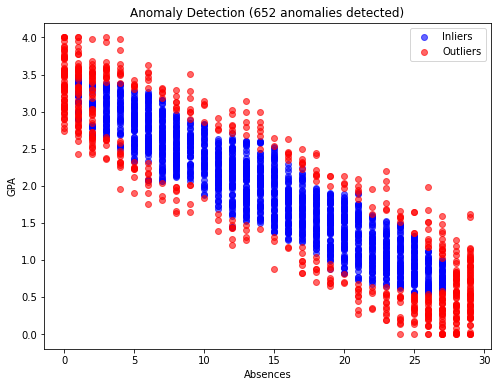

In [5]:
# Extract the selected columns
x_column = 'Absences'
y_column = 'GPA'
X = df[[x_column, y_column]]

# Fit Isolation Forest
clf = IsolationForest(max_samples=len(X))
clf.fit(X)

# Predict anomalies
df['anomaly'] = clf.predict(X)

# Separate inliers and outliers
inliers = df[df['anomaly'] == 1]
outliers = df[df['anomaly'] == -1]

# Count the number of anomalies
num_anomalies = outliers.shape[0]
print(f"Number of anomalies detected: {num_anomalies}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(inliers[x_column], inliers[y_column], c='blue', label='Inliers', alpha=0.6)
plt.scatter(outliers[x_column], outliers[y_column], c='red', label='Outliers', alpha=0.6)
plt.title(f"Anomaly Detection ({num_anomalies} anomalies detected)")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()

,Absences,GPA,Anomaly Score
0,7,2.929196,0.017438
1,0,3.042915,-0.018400
2,26,0.112602,-0.070424
3,14,2.054218,0.066365
4,17,1.288061,0.025962


,Absences,GPA,Anomaly Score
2354,4,3.979421,-0.198404
1260,2,3.984674,-0.182999
1303,29,1.623004,-0.179575
1278,3,4.000000,-0.179447
1327,29,1.584479,-0.176959


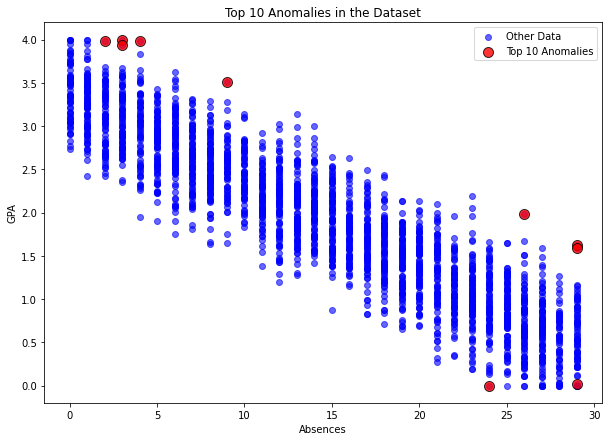

In [6]:
# Calculate anomaly scores
score = clf.decision_function(X)

# Create a DataFrame to store scores and corresponding data
data_scores = pd.DataFrame({
    x_column: X[x_column],
    y_column: X[y_column],
    'Anomaly Score': score
})

# Display the first few rows
display(data_scores.head())

# Sort data_scores by 'Anomaly Score' in descending order
data_scores_sorted = data_scores.sort_values(by='Anomaly Score', ascending=True)

display(data_scores_sorted.head())
# Extract the top 10 anomalies
top_anomalies = data_scores_sorted.head(10)

# Plot the data
plt.figure(figsize=(10, 7))

# Plot the rest of the data
plt.scatter(X[x_column], X[y_column], c='blue', label='Other Data', alpha=0.6)

# Plot the top 10 anomalies
plt.scatter(
    top_anomalies[x_column],
    top_anomalies[y_column],
    c='red',
    label='Top 10 Anomalies',
    alpha=0.8,
    edgecolor='black',
    s=100  # Increase marker size for better visibility
)

# Title and labels
plt.title("Top 10 Anomalies in the Dataset")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()


In [7]:
'''class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.n_nodes = 0
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None

    def fit(self, X, depth=0):
        if depth >= self.max_depth or len(X) <= 1:
            return None
        self.n_nodes += 1

        # Randomly choose a feature and a split value
        n_features = X.shape[1]
        self.split_feature = np.random.randint(0, n_features)
        min_val, max_val = np.min(X[:, self.split_feature]), np.max(X[:, self.split_feature])
        if min_val == max_val:
            return None
        self.split_value = np.random.uniform(min_val, max_val)

        # Partition the data
        left_mask = X[:, self.split_feature] < self.split_value
        right_mask = ~left_mask
        self.left = IsolationTree(self.max_depth)
        self.right = IsolationTree(self.max_depth)

        self.left.fit(X[left_mask], depth + 1)
        self.right.fit(X[right_mask], depth + 1)

    def path_length(self, X):
        path_lengths = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            node = self
            depth = 0
            while node and node.left and node.right:
                if x[node.split_feature] < node.split_value:
                    node = node.left
                else:
                    node = node.right
                depth += 1
            path_lengths[i] = depth
        return path_lengths


class IsolationForest:
    def __init__(self, n_estimators=100, max_samples='auto', max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        n_samples, n_features = X.shape
        if self.max_samples == 'auto':
            self.max_samples = min(256, n_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))

        self.trees = []
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(n_samples, self.max_samples, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(self.max_depth)
            tree.fit(X_sample)
            self.trees.append(tree)

    def anomaly_score(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        path_lengths = np.zeros(X.shape[0])
        for tree in self.trees:
            path_lengths += tree.path_length(X)
        path_lengths /= len(self.trees)

        # Compute anomaly score based on path lengths
        c_n = 2 * (np.log(self.max_samples - 1) + 0.5772156649) - (2 * (self.max_samples - 1) / self.max_samples)
        scores = 2 ** (-path_lengths / c_n)
        return scores

    def predict(self, X, threshold=0.5):
        scores = self.anomaly_score(X)
        return np.where(scores > threshold, -1, 1)  # -1 for anomalies, 1 for normal
    
    def plot(self, X, predictions, feature_names=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Assign colors for anomalies and inliers
        colors = np.array(['blue' if p == 1 else 'red' for p in predictions])
        plt.figure(figsize=(10, 6))

        if X.shape[1] == 2:  # If data has 2 features
            plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', alpha=0.8)
            plt.xlabel(feature_names[0] if feature_names else 'Feature 1')
            plt.ylabel(feature_names[1] if feature_names else 'Feature 2')
        else:  # For more than 2 features, plot only the first two
            plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', alpha=0.8)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Isolation Forest - Anomaly Detection')
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers'),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalies')],
                   loc='upper right')
        plt.grid()
        plt.show()'''

"class IsolationTree:\n    def __init__(self, max_depth):\n        self.max_depth = max_depth\n        self.n_nodes = 0\n        self.split_feature = None\n        self.split_value = None\n        self.left = None\n        self.right = None\n\n    def fit(self, X, depth=0):\n        if depth >= self.max_depth or len(X) <= 1:\n            return None\n        self.n_nodes += 1\n\n        # Randomly choose a feature and a split value\n        n_features = X.shape[1]\n        self.split_feature = np.random.randint(0, n_features)\n        min_val, max_val = np.min(X[:, self.split_feature]), np.max(X[:, self.split_feature])\n        if min_val == max_val:\n            return None\n        self.split_value = np.random.uniform(min_val, max_val)\n\n        # Partition the data\n        left_mask = X[:, self.split_feature] < self.split_value\n        right_mask = ~left_mask\n        self.left = IsolationTree(self.max_depth)\n        self.right = IsolationTree(self.max_depth)\n\n        self.lef

In [8]:
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.is_terminal = False
        self.size = 0

    def fit(self, X, depth=0):
        if depth >= self.max_depth or len(X) <= 1:
            self.is_terminal = True
            self.size = len(X)
            return

        # Randomly choose a feature and split value
        n_features = X.shape[1]
        self.split_feature = np.random.randint(0, n_features)
        min_val, max_val = np.min(X[:, self.split_feature]), np.max(X[:, self.split_feature])

        if min_val == max_val:  # No meaningful split
            self.is_terminal = True
            self.size = len(X)
            return

        self.split_value = np.random.uniform(min_val, max_val)

        # Partition the data
        left_mask = X[:, self.split_feature] < self.split_value
        right_mask = ~left_mask

        self.left = IsolationTree(self.max_depth)
        self.right = IsolationTree(self.max_depth)

        self.left.fit(X[left_mask], depth + 1)
        self.right.fit(X[right_mask], depth + 1)

    def path_length(self, X):
        path_lengths = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            node = self
            depth = 0
            while not node.is_terminal:
                if x[node.split_feature] < node.split_value:
                    node = node.left
                else:
                    node = node.right
                depth += 1
            path_lengths[i] = depth + self._c(node.size)
        return path_lengths

    @staticmethod
    def _c(size):
        """Calculate average path length of a binary tree for given size."""
        if size <= 1:
            return 0
        return 2 * (np.log(size - 1) + 0.5772156649) - (2 * (size - 1) / size)


class IForest:
    def __init__(self, n_estimators=100, max_samples=256, max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        n_samples, n_features = X.shape
        self.max_samples = min(self.max_samples, n_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))

        self.trees = []
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(n_samples, self.max_samples, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(self.max_depth)
            tree.fit(X_sample)
            self.trees.append(tree)

    def anomaly_score(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        path_lengths = np.zeros(X.shape[0])
        for tree in self.trees:
            path_lengths += tree.path_length(X)
        path_lengths /= len(self.trees)

        # Compute anomaly score based on path lengths
        c_n = 2 * (np.log(self.max_samples - 1) + 0.5772156649) - (2 * (self.max_samples - 1) / self.max_samples)
        scores = 2 ** (-path_lengths / c_n)
        return scores

    def predict(self, X, threshold=0.5):
        scores = self.anomaly_score(X)
        return np.where(scores > threshold, -1, 1)  # -1 for anomalies, 1 for normal

    def plot(self, X, predictions, feature_names=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Assign colors for anomalies and inliers
        colors = np.array(['blue' if p == 1 else 'red' for p in predictions])
        plt.figure(figsize=(10, 6))

        if X.shape[1] == 2:  # If data has 2 features
            plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', alpha=0.8)
            plt.xlabel(feature_names[0] if feature_names else 'Feature 1')
            plt.ylabel(feature_names[1] if feature_names else 'Feature 2')
        else:  # For more than 2 features, plot only the first two
            plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', alpha=0.8)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Isolation Forest - Anomaly Detection')
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers'),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalies')],
                   loc='upper right')
        plt.grid()
        plt.show()


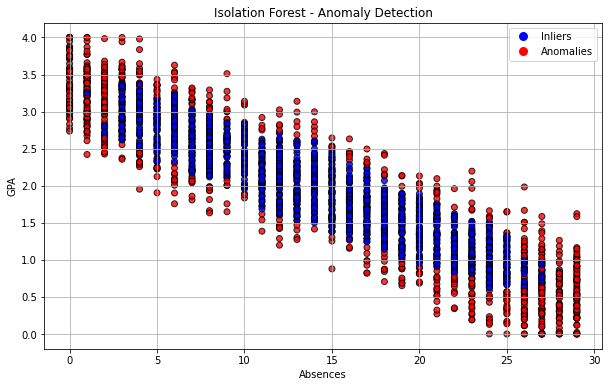

Anomaly Scores: [0.48678672 0.54174576 0.55866053 ... 0.46596876 0.45067467 0.42325976]
Predictions: [ 1 -1 -1 ...  1  1  1]


In [9]:
iforest = IForest(n_estimators=100, max_samples=len(df[['Absences', 'GPA']]), max_depth=100)
iforest.fit(df[['Absences', 'GPA']])

# Predict anomalies
scores = iforest.anomaly_score(df[['Absences', 'GPA']])
predictions = iforest.predict(df[['Absences', 'GPA']])

iforest.plot(df[['Absences', 'GPA']], predictions, feature_names=['Absences', 'GPA'])

print("Anomaly Scores:", scores)
print("Predictions:", predictions)

Top 10 anomaly scores with corresponding IDs:
ID: 2048, Anomaly Score: 0.6741372888235904
ID: 474, Anomaly Score: 0.6654425780596634
ID: 1303, Anomaly Score: 0.6588384688935875
ID: 2354, Anomaly Score: 0.6535783145573214
ID: 1278, Anomaly Score: 0.6483771875441253
ID: 2172, Anomaly Score: 0.6467970090729787
ID: 1327, Anomaly Score: 0.6462803989420357
ID: 1105, Anomaly Score: 0.6420246965018012
ID: 879, Anomaly Score: 0.6404308156416227
ID: 1260, Anomaly Score: 0.6403077445586838


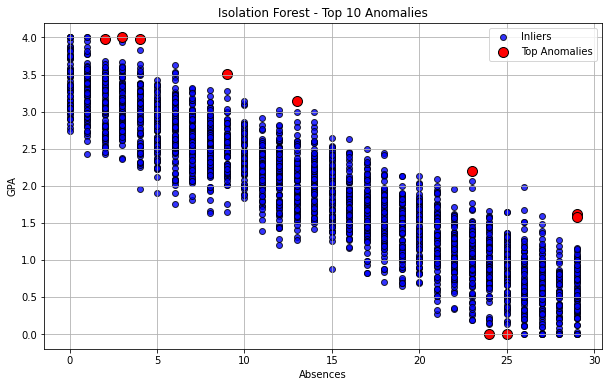

In [10]:
top_anomalies = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:10]  # Lower scores = more anomalous
top_anomaly_indices = [idx for idx, _ in top_anomalies]

print("Top 10 anomaly scores with corresponding IDs:")
for idx, score in top_anomalies:
    print(f"ID: {idx}, Anomaly Score: {score}")
        
plt.figure(figsize=(10, 6))

# Plot inliers
inlier_mask = ~df.index.isin(top_anomaly_indices)
plt.scatter(df.loc[inlier_mask, 'Absences'], df.loc[inlier_mask, 'GPA'], color='blue', label='Inliers', edgecolor='k', alpha=0.8)

# Plot anomalies
plt.scatter(df.loc[top_anomaly_indices, 'Absences'], df.loc[top_anomaly_indices, 'GPA'], color='red', label='Top Anomalies', edgecolor='k', s=100)

# Add labels and legend
plt.xlabel('Absences')
plt.ylabel('GPA')
plt.title('Isolation Forest - Top 10 Anomalies')
plt.legend(loc='upper right')
plt.grid()
plt.show()